In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay-travel cluster classification in 1D: homebrew

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

## Meth

1. Cut the trajectory into coarse sections
    * do forward and backward, with different epsilons
2. for each of the cut sections,
    1. remove the outliers with IQR
    2. refine the sections with the matrix minimum $\to$ identify as "stays"
3. al non-stays are travels

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

# Sythetic data

In [6]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.trajectory_class import get_trajectory

dsec = 1/3600.0
time = np.arange(0,24,dsec)
'''stays = [
        get_stay(  0.00,  6.40,-1.00), #home
        get_stay(  6.50, 17.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]'''

stays = [
        get_stay(  0,  6.40,  1),
        get_stay( 6.50,  18.0, -0.5),
        get_stay( 18.1,  19.5,  0.5),
        get_stay( 19.6,  20.9,  2.5),
        get_stay( 21.0, 24,  1)
    ]


configs = {
    'threshold':0.5,
    'event_frac':0.05,
    'duplicate_frac':0.3,    
    'noise_min':0.02,
    'noise_max':0.15
}


time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

In [7]:
noise_journey_sub.size

4319

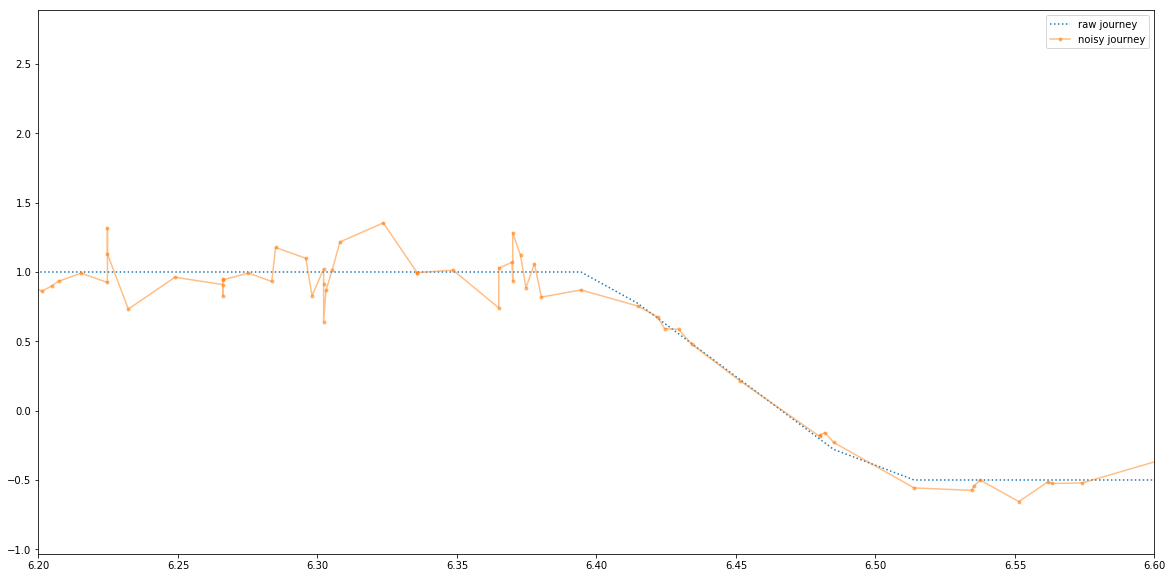

In [8]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend()
plt.xlim([6.2,6.6]);

In [9]:
np.where((time_sub>=6.4) & (time_sub<6.45))

(array([1117, 1118, 1119, 1120, 1121]),)

In [10]:
from time import time

at row 100, Dt =  3.2826590538024902
at row 200, Dt =  2.912623882293701
at row 300, Dt =  2.5525951385498047
at row 400, Dt =  2.3529212474823
at row 500, Dt =  1.8211944103240967
at row 600, Dt =  1.5294687747955322
at row 700, Dt =  1.2617998123168945
at row 800, Dt =  0.9876532554626465
at row 900, Dt =  0.7314705848693848
at row 1000, Dt =  0.4741857051849365
at row 1100, Dt =  0.20795822143554688


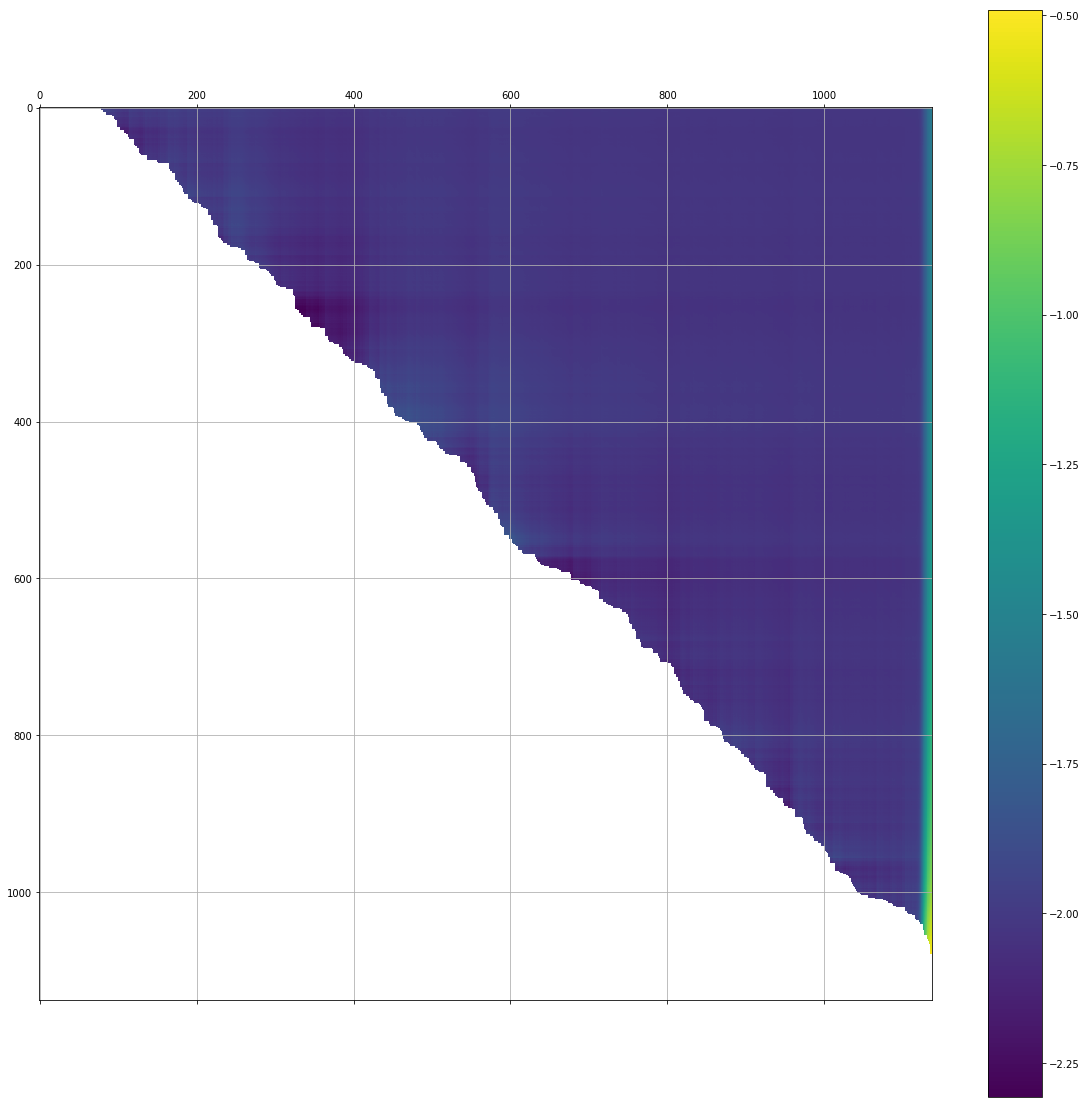

In [11]:
time_thresh = 5/12
# Start with the subregion
time_sub_sub = time_sub[0:1138]

# Get the time features of the subregion: map the interval to [0,1]
tss_diff = time_sub_sub[-1]-time_sub_sub[0]
T_max = time_sub_sub[-1]
T_min = time_sub_sub[0]
t_score = lambda t: (T_max-t)/(T_max-T_min)

# Get the matrix of stddevs 
# * find the min & max to rescale the interval
# * rescale to also include time-weights 
#S = lil_matrix((len(time_sub_sub),len(time_sub_sub)))
shape = (len(time_sub_sub),len(time_sub_sub))
S = np.empty(shape=shape)
S.fill(np.nan)



t0 = time()
# Get the min and max of the matrix-stds
'''
for row in range(1,len(time_sub_sub)-1):        
    for col in range(row+1,len(time_sub_sub)):  
''' 
'''smin=100
for row in range(1,100):        
    for col in range(row+1,100):  
        
        S[row,col] = np.std(noise_journey_sub[row:col+90])
        smin = min(smin,S[row,col])
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1, smin)
        t0 =t1     
        
print(smin)       
# Get the cluster spreads of the subregion: map the interval to [0,1]
S_max = S.todense().max() #S.max()
S_min = S.todense().min() #S.min()        
s_score = lambda s: s/(S_max-S_min)
print(S_min,smin)
'''
s_score = lambda s: s_metric(s,5*eps,eps)

t0 = time()

# Recompute the matrix;
'''
for row in range(1,len(time_sub_sub)-1):
    for col in range(row+1,len(time_sub_sub)):
'''        
'''for row in range(100):        
    for col in range(row+1,100):          
'''        
for row in range(1,len(time_sub_sub)-1):        
    for col in range(row+1,len(time_sub_sub)):  
        
        #delta_t = abs(time_sub[row+1180]-time_sub[col+1180])
        delta_t = abs(time_sub[row]-time_sub[col])
        #tscore = t_score(delta_t)
        #tscore = t_score(abs(time_sub_sub[row]-time_sub_sub[col+90]))
        
        #ss = np.std(noise_journey_sub[row+1180:col+1180])
        #sscore = s_score(ss) #
        sscore = np.std(noise_journey_sub[row:col])
        
        if delta_t < time_thresh:
            #print(row,col,delta_t)
            S[row,col] = np.nan
        else:
            
            S[row,col] = np.log(sscore)#np.log(np.norm([sscore,tscore]))
            
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1)
        t0 =t1           
#plt.figure(figsize=[20,20])
fig, ax = plt.subplots(1,1,figsize=[20,20])
thing = ax.matshow(S)#, vmin=0,vmax=.2)
#fig.colorbar()
plt.colorbar(thing)
plt.grid()

In [12]:
t0 = time()

norm  = lambda vals :np.linalg.norm([vals])

S = np.empty(shape=shape)
S.fill(np.nan)

for row in range(1,len(time_sub_sub)-1):        
    for col in range(row+1,len(time_sub_sub)):  
        
        #delta_t = abs(time_sub[row+1180]-time_sub[col+1180])
        delta_t = abs(time_sub[row]-time_sub[col])
        #tscore = t_score(delta_t)
        #tscore = t_score(abs(time_sub_sub[row]-time_sub_sub[col+90]))
        
        #ss = np.std(noise_journey_sub[row+1180:col+1180])
        #sscore = s_score(ss) #
        sscore = np.std(noise_journey_sub[row:col])
        
        if delta_t < time_thresh:
            #print(row,col,delta_t)
            S[row,col] = np.nan
        else:
            tscore = 1/delta_t
            S[row,col] = np.log(norm([sscore,tscore]))
            
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1)
        t0 =t1           

at row 100, Dt =  4.30445122718811
at row 200, Dt =  4.120757102966309
at row 300, Dt =  3.8523261547088623
at row 400, Dt =  3.0776562690734863
at row 500, Dt =  2.776700019836426
at row 600, Dt =  2.4085893630981445
at row 700, Dt =  1.9298627376556396
at row 800, Dt =  1.6289844512939453
at row 900, Dt =  1.2483932971954346
at row 1000, Dt =  0.7670466899871826
at row 1100, Dt =  0.26458287239074707


In [13]:
time_sub_sub.shape, np.unique(time_sub_sub).shape

((1138,), (807,))

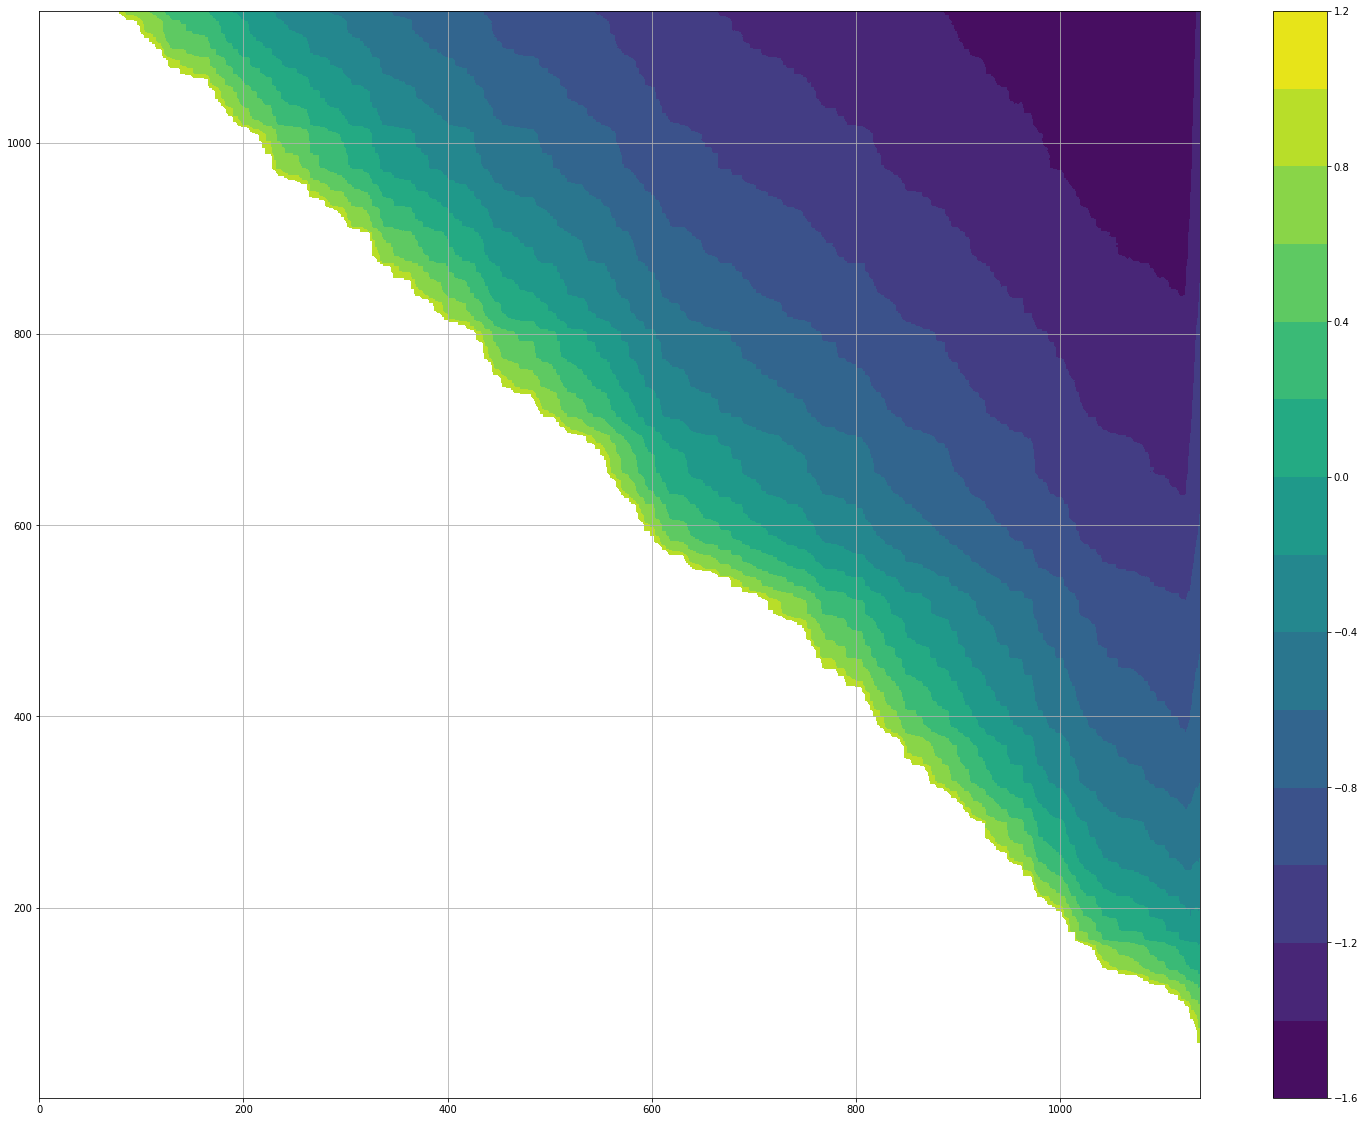

In [14]:
x = np.arange(0, 1138)
y = np.arange(1138,0,-1 )
X, Y = np.meshgrid(x, y)

from matplotlib import cm
          
fig, ax = plt.subplots(1,1,figsize=[26,20])
#thing = ax.matshow(S)#, vmin=0,vmax=.2)
ax.contourf(X, Y, S) 



# Boost the upper limit to avoid truncation errors.
levels = np.arange(-1.6, 1.3, 0.2)

norm = cm.colors.Normalize(vmax=abs(S).max(), vmin=-abs(S).max())
cmap = cm.PRGn

cf = ax.contourf(X, Y, S, levels)
#, levels, norm=norm,
#                     cmap=cm.get_cmap(cmap, len(levels) - 1))
fig.colorbar(cf, ax=ax)

#fig.colorbar()
#plt.colorbar(thing)
plt.grid()

### With time

In [80]:
time_sub_sub = time_sub[:1180]#:3000]

time_sub_uniq = np.unique(time_sub_sub)
size = time_sub_uniq.size
print(size, 3000-1180)
shape = (size,size)
S = np.empty(shape=shape)
S.fill(np.nan)

833 1820


In [81]:
norm  = lambda vals :np.linalg.norm([vals])

In [82]:
t0 = time()

t_max = time_sub_uniq.max()-time_sub_uniq.min()

nind = np.where(time_sub == time_sub_uniq.min())[0].min()
xind = np.where(time_sub == time_sub_uniq.max())[0].max()
print(nind, xind, t_max)
s_max = 1.01*np.std(noise_journey_sub[nind:xind])

0 1179 6.8075


**Notes**
1. want a metric which is minimized for
    * smallest $\mathrm{std}$ but largest $\Delta t$
        * largest $\Delta t$ should be that of the suspected segment $\to$ _but_ this segment is unknown!
    * metric should be some (balanced) combination of these two
2. want a normalization for $t$- and $x$-metrics
    * otherwise, the time gradient would be the overwhelming the std-gradient
    * the no

In [83]:
for row in range(1,len(time_sub_uniq)-1):        
    for col in range(row+1,len(time_sub_uniq)):  
        
        row_ = np.where(time_sub == time_sub_uniq[row])[0].min()
        col_ = np.where(time_sub == time_sub_uniq[col])[0].max()
        
        #delta_t = abs(time_sub[row+1180]-time_sub[col+1180])
        delta_t = abs(time_sub[row_]-time_sub[col_])
        #tscore = t_score(delta_t)
        #tscore = t_score(abs(time_sub_sub[row]-time_sub_sub[col+90]))
        
        #ss = np.std(noise_journey_sub[row+1180:col+1180])
        #sscore = s_score(ss) #
        sscore = np.std(noise_journey_sub[row_:col_])
        #s_max = max(s_max,sscore)
        
        if delta_t < time_thresh:
            #print(row,col,delta_t)
            S[row,col] = np.nan
        else:
            
            tscore = 1/delta_t
            #t_max = max(t_max,tscore)
            #print(tscore,'and',sscore, norm([sscore,tscore]))
            S[row,col] = np.log(sscore)#norm( [sscore/s_max,tscore/t_max]))
            
    if row%100==0: 
        t1 = time()
        print(f'at row {row}, Dt = ', (t1-t0)/1)
        t0 =t1           

at row 100, Dt =  4.441179513931274
at row 200, Dt =  3.295661687850952
at row 300, Dt =  2.8167600631713867
at row 400, Dt =  2.3155996799468994
at row 500, Dt =  1.8258330821990967
at row 600, Dt =  1.3551297187805176
at row 700, Dt =  0.8608412742614746
at row 800, Dt =  0.387498140335083


In [99]:
print(S[np.where(np.isnan(S)==False)].min(), S[np.where(np.isnan(S)==False)].max())
s_min = S[np.where(np.isnan(S)==False)].min()
s_max = S[np.where(np.isnan(S)==False)].max()
lev = max(abs(s_min), abs(s_max))
dlev = (s_max-s_min)/20 #2*lev/20
print(lev, dlev)

-2.301420882384656 -0.2940088003187673
2.301420882384656 0.10037060410329443


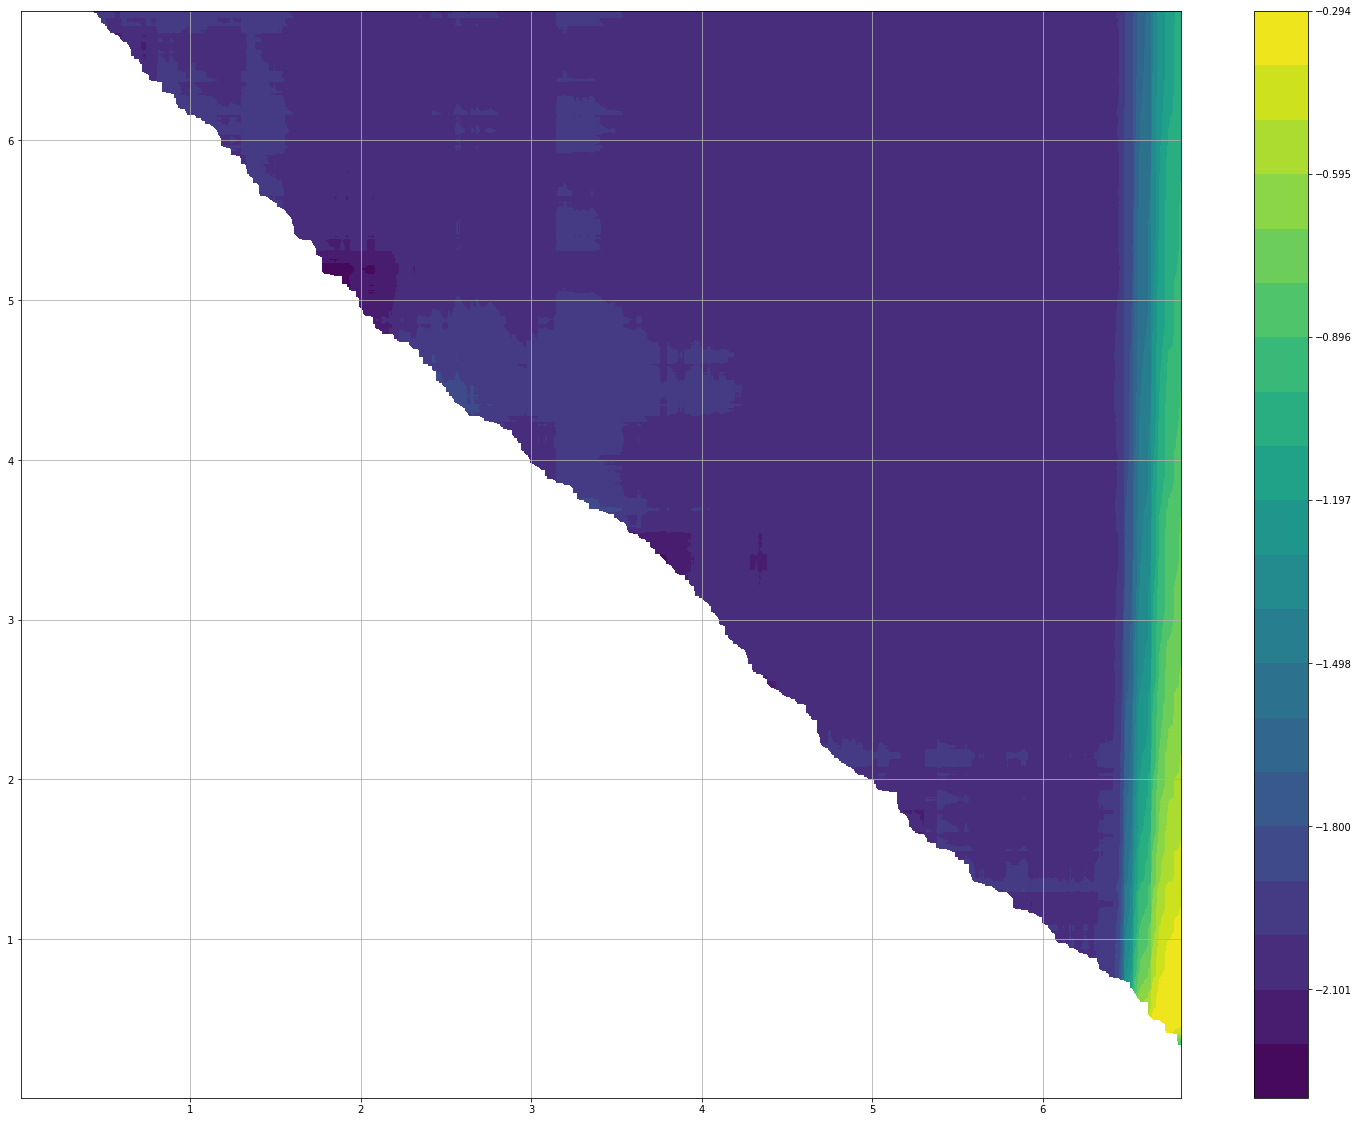

In [105]:
x = time_sub_uniq #np.arange(0, 1138)
y = time_sub_uniq[::-1] #np.arange(1138,0,-1 )
X, Y = np.meshgrid(x, y)

from matplotlib import cm
          
fig, ax = plt.subplots(1,1,figsize=[26,20])

# Boost the upper limit to avoid truncation errors.
levels = np.arange(s_min, s_max+dlev, dlev)

#lnorm = cm.colors.Normalize(vmax=abs(S).max(), vmin=-abs(S).max())
cmap = cm.PRGn

cf = ax.contourf(X, Y, S, levels)
#, levels, norm=norm,
#                     cmap=cm.get_cmap(cmap, len(levels) - 1))
fig.colorbar(cf, ax=ax)

#fig.colorbar()
#plt.colorbar(thing)
plt.grid()

From [dummy-output-no-sound-in-ubuntu-16-04](https://askubuntu.com/questions/914463/dummy-output-no-sound-in-ubuntu-16-04)

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [10]:
time_thresh = 1/12.
eps=0.25

In [11]:
clusters = list(range(noise_journey_sub.size))

In [12]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [13]:
def get_clusters(times, positions, dist_thresh, time_thresh):

    # The list of found clusters
    clusters = []

    # index var.
    m = 0
    
    # 
    new_cluster = []
    for n in range(0,positions.size-3):

        # Check temporal connectedness: look for breaks in the time > thresh
        if times[n+1] <= times[n]+time_thresh:

            get_y = positions[n+1]

        else: 
            continue

        # Check spatial connectedness:
        # Get the current cluster mean
        cluster_mean = np.mean(positions[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(positions[m:n+2])

        err1 = get_err(cluster_mean, get_y)
        err2 = get_err(cluster_mean, new_cluster_mean)

        #print(n, err1, err2, dist_thresh)

        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= positions.size-5):

            new_cluster.append(n)
            #print(len(new_cluster))
        else:
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            #print(txt+app)

            new_cluster = []

            m=n+1
            
    return clusters

In [14]:
clusters = get_clusters(time_sub, noise_journey_sub, eps, time_thresh)
len(clusters)

20

for clust in clusters:
    print(clust)

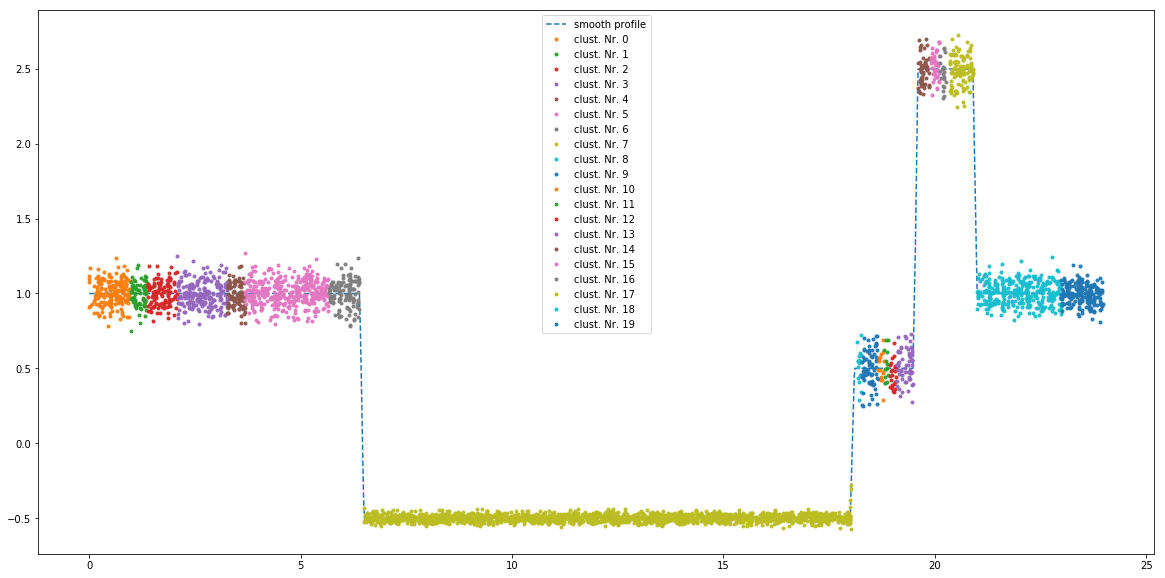

In [15]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')

for cl_nr, clust in enumerate(clusters):
    plt.plot(time_sub[clust], noise_journey_sub[clust], '.', alpha=0.95, label=f'clust. Nr. {cl_nr}')

plt.legend();

```
# Calculate first and third quartile
# the the quantiled std
q25 = np.quantile(time_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(time_sub[m:nn],0.75, interpolation='higher')

# Interquartile range
iqr = q75 - q25

# Remove outliers
q75_ind = np.max(np.where(time_sub[m:nn] < (q75 + 3 * iqr)))
q25_ind = np.min(np.where(time_sub[m:nn] > (q25 - 3 * iqr)))
```

In [16]:
m=0
nn=117
q25 = np.quantile(noise_journey_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(noise_journey_sub[m:nn],0.75, interpolation='higher')

print(np.quantile(noise_journey_sub[m:nn],[0.25, 0.5, 0.75], interpolation='higher'))
#print()

#print(np.sort(noise_journey_sub[m:nn]))
# Interquartile range

iqr = abs(q75 - q25)
iqr_fact = 3

print()
print(q25, q75, iqr,(q25 - iqr_fact * iqr), (q75 + iqr_fact * iqr))
iqr_fact = 0
print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
mask=np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr)))
print(noise_journey_sub[m:nn].size, np.std(noise_journey_sub[m:nn]),noise_journey_sub[mask].size, np.std(noise_journey_sub[mask]))

[0.93639255 1.0043702  1.06613788]

0.9363925483282053 1.066137879449519 0.1297453311213138 0.5471565549642639 1.4553738728134604
0 117 (array([  7,   9,  10,  11,  14,  15,  17,  18,  20,  23,  25,  26,  28,
        33,  36,  37,  38,  39,  41,  47,  48,  49,  51,  56,  57,  59,
        64,  65,  66,  70,  73,  74,  76,  77,  78,  80,  81,  83,  88,
        90,  91,  92,  93,  94,  95,  97,  99, 101, 102, 104, 106, 107,
       109, 110, 111, 114, 115]),)
117 0.08247431007555087 57 0.03331506187925971


In [17]:
def get_iqr_masked(positions, iqr_fact = 3):
    # Calculate first and third quartiles
    q25 = np.quantile(positions,0.25, interpolation='lower')
    q75 = np.quantile(positions,0.75, interpolation='higher')

    # Calculate the interquartile range (IQR)
    iqr = abs(q75 - q25)

    #print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
    mask=np.where(  (positions > (q25 - iqr_fact * iqr)) \
                  & (positions < (q75 + iqr_fact * iqr)))    
    
    return mask

def get_iqr_std(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.std(positions[mask])
    else:
        return positions[0]

def get_iqr_avg(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.mean(positions[mask])
    else:
        return positions[0]

In [18]:
def get_batch_clusters(times, positions, dist_thresh, time_thresh):

    # Get the max length of any cluster
    max_len = positions.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    while ind < max_len:

        
        # Set the time buffer around the last point of the current cluster
        # look for the next temporally connected event
        # NOTE: _all_ events can be connected if the samp. freq. is high enough!
        # TODO: try something else!!!
        nn=m+1
        while (times[nn]-last_time_point <= time_thresh) & (nn<=max_len):
            nn+=1

        #print(m,nn, positions[m:nn].shape)
        
        if positions[m:nn].size > 1:
            
            # Get the current cluster std
            cluster_std = np.std(positions[m:nn])
            cluster_qstd = get_iqr_std(positions[m:nn])
            
        else:
            cluster_std = 0.0
            cluster_qstd = 0.0
        
        nnn=nn
        while ((positions[m:nnn].size > 1) & ((cluster_std >= dist_thresh) | (cluster_qstd >= dist_thresh))):
            print('\t\trefinement', nnn, cluster_std, cluster_qstd)
            # Get the current cluster std
            cluster_std = np.std(positions[m:nnn])
            cluster_qstd = get_iqr_std(positions[m:nnn])
            nnn-=1

        # Check!
        print('STD-testing at', nn, cluster_std, cluster_qstd, dist_thresh)
        # 
        new_cluster = list(range(m,nnn+1))

        # if the std's are good, keep the cluster, and update the final time point
        if  (cluster_std < dist_thresh) & (cluster_qstd < dist_thresh) & (nnn<max_len) & (nnn==nn) :

            last_time_point = times[nnn]
            ind = nnn

        else:
            txt = f'Trying {len(new_cluster)} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            print(txt+app)

            new_cluster = []
            if (nnn==nn):
                ind=nn
                m=nn
            else:
                ind=nnn
                m=nnn
            
    return clusters

In [19]:
get_normd_err = lambda x,mu,thresh: ((x-mu)/thresh)
get_norm_diff = lambda diff,denom: diff/denom
norm  = lambda vals :np.linalg.norm([vals])

In [20]:
def get_batch_clusters2(times, locs, dist_thresh, time_thresh):

    
    # Get the max length of any cluster
    max_len = locs.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    continuing = True
    while continuing:
        
        # Get a primitive cluster
        nn=m+1
        last_time_point = times[m]
        check_norm = True
        while check_norm:

            # Some statistics: std, IQR-std, IQR-mean
            cluster_std = np.std(locs[m:nn])
            cluster_avg = np.mean(locs[m:nn])
            cluster_qstd = get_iqr_std(locs[m:nn])            
            cluster_qavg = get_iqr_avg(locs[m:nn])            

            #print(locs[m:nn],cluster_std,locs[nn])
            # Some local info: current x,t
            tval  = get_norm_diff(times[nn]-last_time_point, time_thresh)

            next_loc =locs[nn]
            x1val = 0.0 #get_norm_diff(locs[nn]-cluster_avg,  dist_thresh)   
            x2val = get_norm_diff(next_loc-cluster_qavg, dist_thresh)   
            s1val = 0.0 #get_norm_diff(locs[nn]-cluster_std,  dist_thresh)
            s2val = get_norm_diff(next_loc-cluster_qstd, dist_thresh)

            the_norm1 = norm([x2val,tval])
            the_norm2 = norm([x1val,x2val,s1val,s2val,tval])

            print(x1val,x2val,s1val,s2val,tval,the_norm1,the_norm2, len(locs[m:nn]))

            check_norm = the_norm2 < 1

            if check_norm:
                last_time_point = times[nn]
                nn+=1
        clusters.append([m,nn])
        print([m,nn])
        m=nn
        continuing = m < max_len
        
    return clusters

In [21]:
np.sqrt(2*((0.5)**2))

0.7071067811865476

In [22]:
((1-np.mean([1,2]))**2)+((2-np.mean([1,2]))**2)

0.5

In [23]:
np.sqrt(np.std([1,2]))

0.7071067811865476

### the metrics: what changes and how

In [117]:
m = 0
nn = 1
columns=['t', 'x', 'dt', 'm1', 'm2', 'd1', 'qd', 's1', 'qs', 's1n', 'qsn']
pdf_traj = pd.DataFrame(columns=columns)
last_time_point = time_sub[0]

switch_indices = []
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_sub[m:nn]) #cluster std, 's1n'
    cluster_avg = np.mean(noise_journey_sub[m:nn]) #cluster mean, 'd1'
    cluster_qstd = get_iqr_std(noise_journey_sub[m:nn+1]) # cluster iqr std, 'qsn'
    cluster_qavg = get_iqr_avg(noise_journey_sub[m:nn+1]) # cluster iqr mean, 'qd'  

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_sub[nn]-last_time_point, time_thresh) # time diff, 'dt'

    next_loc =noise_journey_sub[nn]
    x1val = get_norm_diff(next_loc-cluster_avg,  eps) # distance between next point and cluster mean, 'm1'
    x2val = get_norm_diff(next_loc-cluster_qavg, eps) # distance between next point and cluster iqr mean, 'm2'
    s1val = get_norm_diff(cluster_std,  eps) # normalized std, 's1'
    s2val = get_norm_diff(cluster_qstd, eps) #normalized iqr std, 'qs'

    
    pdf_ = pd.DataFrame(data=[[time_sub[nn],noise_journey_sub[nn],
                         tval, x1val, x2val, cluster_avg, cluster_qavg,
                         s1val, s2val, cluster_std, cluster_qstd]],
                           columns=columns)
    pdf_traj = pd.concat([pdf_traj, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_sub[nn]
    if (s1val > 1.0) & (tval != 0):
        print(nn, time_sub[nn])
        switch_indices.append(nn)
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_traj.reset_index(drop=True, inplace=True)

1234 6.650277777777778
3428 18.945
3520 19.56388888888889
3522 19.605
3794 21.011111111111113


In [118]:
pdf_traj.head(5)

,t,x,dt,m1,m2,d1,qd,s1,qs,s1n,qsn
0,0.005000,1.075902,0.030000,-0.174430,-0.087215,1.119509,1.097705,0.000000,0.087215,0.000000,0.021804
1,0.005556,1.093531,0.006667,-0.016698,-0.011132,1.097705,1.096314,0.087215,0.071644,0.021804,0.017911
2,0.006944,0.909456,0.016667,-0.747433,-0.560575,1.096314,1.049599,0.071644,0.329542,0.017911,0.082385
3,0.015833,0.918672,0.106667,-0.523709,-0.418967,1.049599,1.023414,0.329542,0.361609,0.082385,0.090402
4,0.019722,1.173431,0.046667,0.600069,0.500057,1.023414,1.048417,0.361609,0.398722,0.090402,0.099681


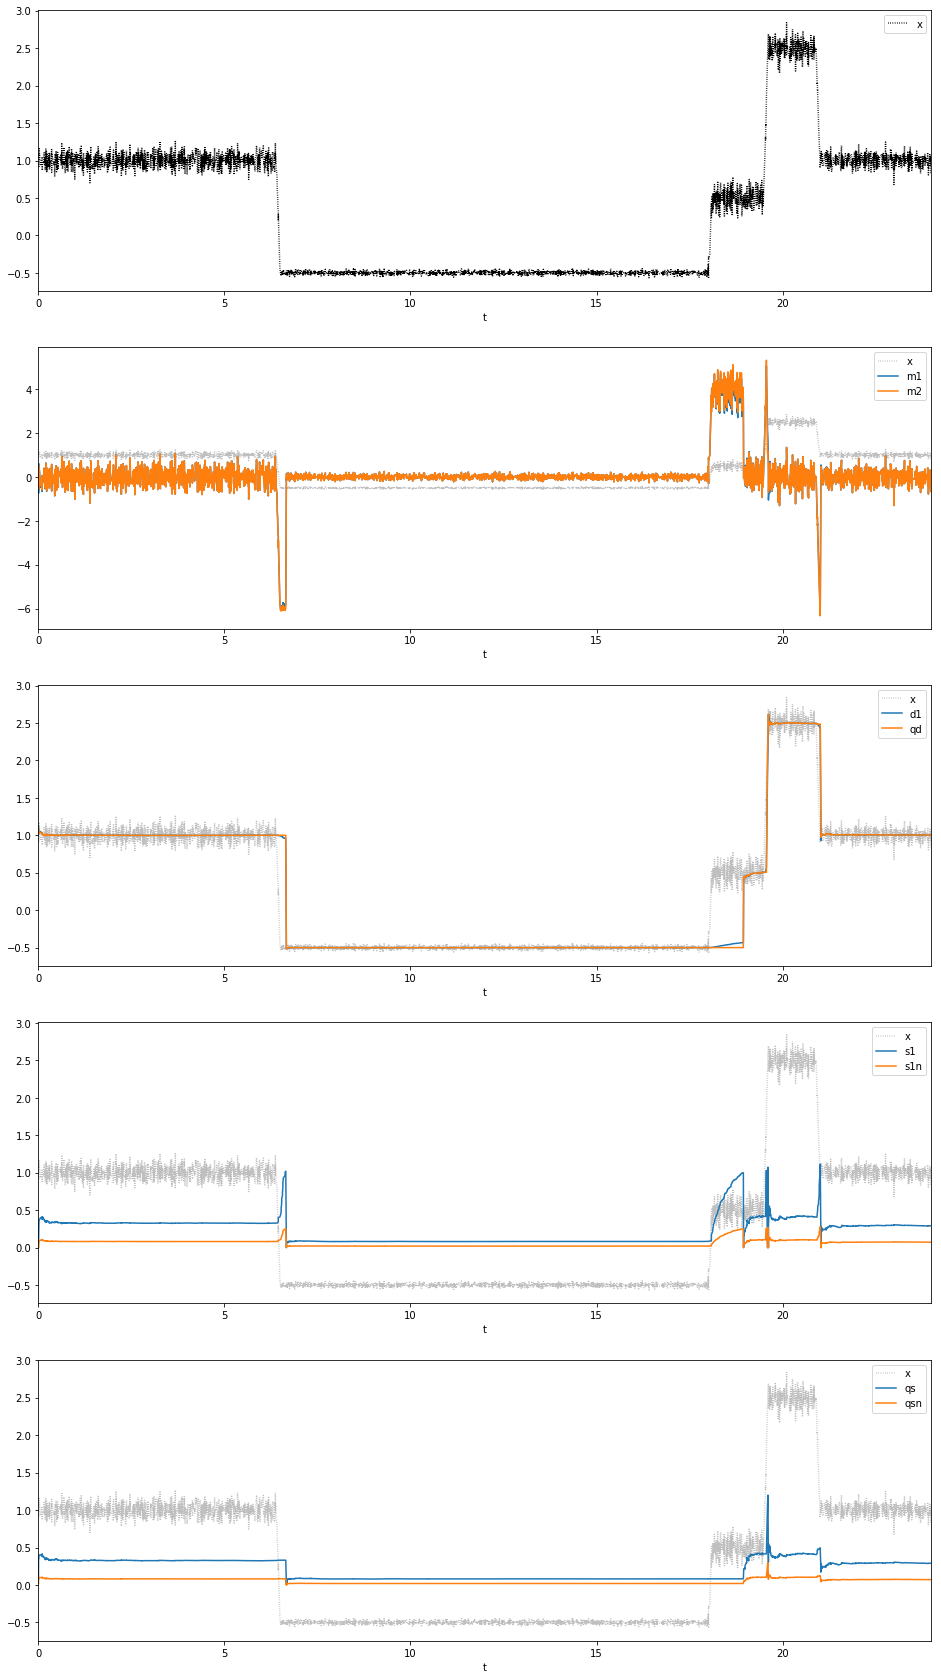

In [119]:
fig, axs = plt.subplots(5,1,figsize=[16,30])
axs = axs.reshape(5)

ax = axs[0]
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)

ax = axs[1]
pdf_traj.plot(x='t',y=['x'], color='gray',linestyle='--', dashes=[0.5,1],ax=ax, alpha=0.5)
pdf_traj.plot(x='t',y=['m1', 'm2'],  ax=ax)
ax.legend()

ax = axs[2]
pdf_traj.plot(x='t',y=['x'], color='gray',linestyle='--', dashes=[0.5,1],ax=ax, alpha=0.5)
pdf_traj.plot(x='t',y=['d1', 'qd'],  ax=ax)
ax.legend()

ax = axs[3]
pdf_traj.plot(x='t',y=['x'], color='gray',linestyle='--', dashes=[0.5,1],ax=ax, alpha=0.5)
pdf_traj.plot(x='t',y=['s1', 's1n'],  ax=ax)
ax.legend()

ax = axs[4]
pdf_traj.plot(x='t',y=['x'], color='gray',linestyle='--', dashes=[0.5,1],ax=ax, alpha=0.5)
pdf_traj.plot(x='t',y=['qs', 'qsn'],  ax=ax)
ax.legend()

**Note** as with any average, the long central segment pulls its weight into the neighboring segments, bringig their averages closer to it.

In [120]:
pdf_traj.reset_index(drop=True, inplace=True)

In [121]:
m = 0
nn = 1

noise_journey_subr = noise_journey_sub[::-1]
time_subr = time_sub[::-1]

switch__indices = []

columns=['t', 'x', 'dt', 'm1', 'm2', 'd1', 'qd', 's1', 'qs', 's1n', 'qsn']
pdf_trajr = pd.DataFrame(columns=columns)
last_time_point = time_subr[0]
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_subr[m:nn])
    cluster_avg = np.mean(noise_journey_subr[m:nn])
    cluster_qstd = get_iqr_std(noise_journey_subr[m:nn+1])            
    cluster_qavg = get_iqr_avg(noise_journey_subr[m:nn+1])            

    #print(noise_journey_subr[m:nn],cluster_std,noise_journey_subr[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_subr[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_subr[nn]
    x1val = get_norm_diff(next_loc-cluster_avg,  eps)   
    x2val = get_norm_diff(next_loc-cluster_qavg, eps)   
    s1val = get_norm_diff(cluster_std,  eps)
    s2val = get_norm_diff(cluster_qstd, eps)

    
    pdf_ = pd.DataFrame(data=[[time_subr[nn],noise_journey_subr[nn],
                         tval, x1val, x2val, cluster_avg, cluster_qavg,
                         s1val, s2val, cluster_std, cluster_qstd]],
                           columns=columns)
    pdf_trajr = pd.concat([pdf_trajr, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_subr[nn]
    if (s1val > 1.0) & (tval != 0):        
        print(nn, time_subr[nn])
        switch__indices.append(nn)
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_subr[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_subr[m:nn]))

pdf_trajr.reset_index(drop=True, inplace=True)

557 20.843055555555555
807 19.468055555555555
1052 17.9775
3184 6.1175


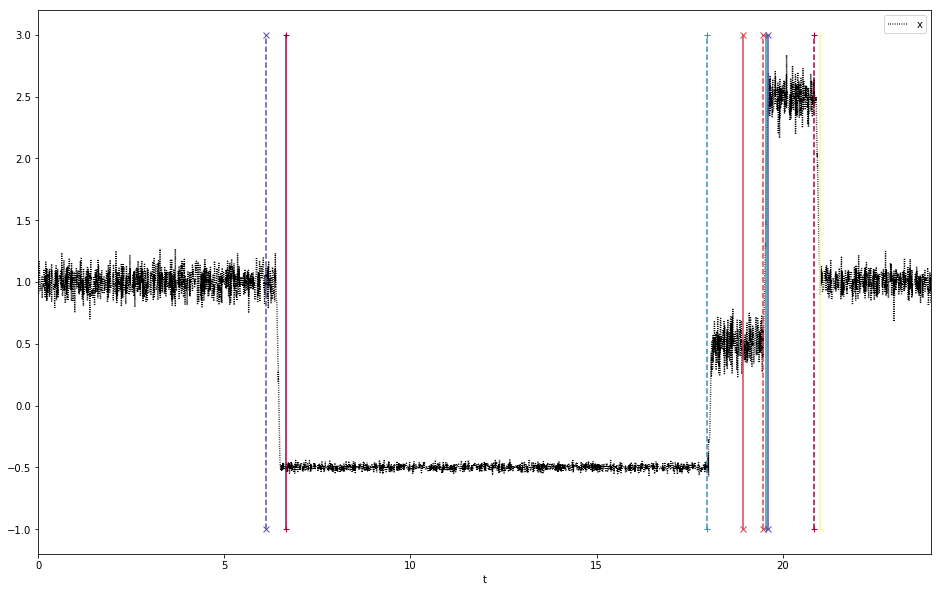

In [129]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)

ind = 0
for n in switch_indices:
    color =colors[ind]
    
    if ind%2 == 0:
        marker='+'
    else:
        marker='x'
        
    ax.plot([time_sub[n],time_sub[n]],[-1,3], color=color, marker=marker, linestyle='-', )
    ind+=1
    
ind = 0
for n in switch__indices:
    color =colors[ind]
    
    if ind%2 == 0:
        marker='+'
    else:
        marker='x'
        
    ax.plot([time_subr[n],time_subr[n]],[-1,3], color=color, marker=marker, linestyle='--', )
    ind+=1
    
ax.legend();

#ax.set_xlim([16,20])

In [122]:
switchr_indices = []

for n in switch__indices:
    
    nn = np.where(time_sub==time_subr[n])[0].tolist()
    switchr_indices += nn
switchr_indices = sorted(switchr_indices)

In [123]:
switch_indices = sorted(switch_indices)

In [124]:
switch_indices, switchr_indices

([1234, 3428, 3520, 3522, 3794], [1134, 3265, 3266, 3511, 3761])

In [114]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle
shuffle(colors)

6.633055555555556 6.1175
18.950833333333332 17.9775
19.56388888888889 17.9775
19.605 19.468055555555555
21.002777777777776 20.843055555555555


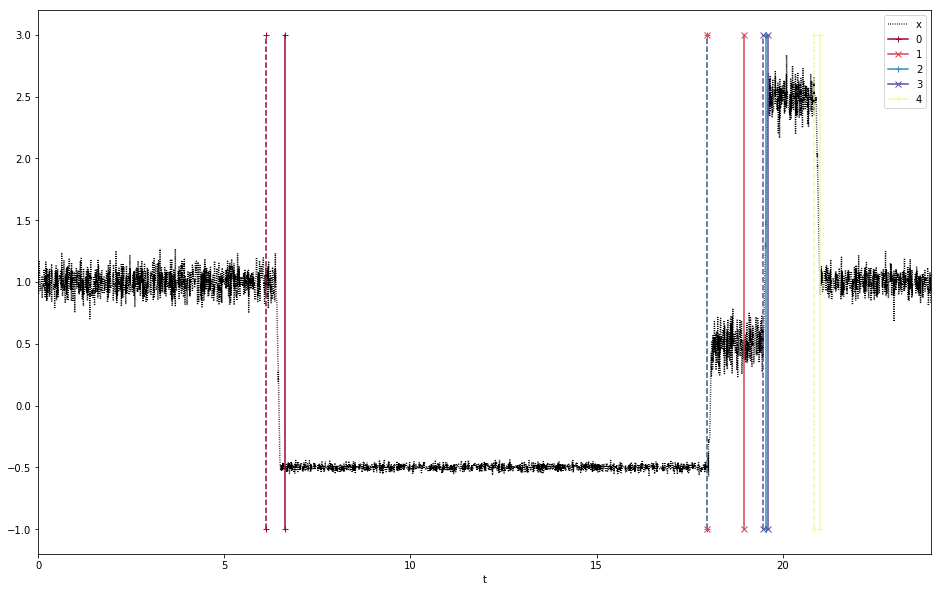

In [116]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)

ind = 0
for m,n in list(zip(switch_indices,switchr_indices)):
    color =colors[ind]
    print(time_sub[m],time_sub[n])
    
    if ind%2 == 0:
        marker='+'
    else:
        marker='x'
        
    ax.plot([time_sub[m],time_sub[m]],[-1,3], color=color, marker=marker, linestyle='-', label=f'{ind}')
    ax.plot([time_sub[n],time_sub[n]],[-1,3], color=color, marker=marker, linestyle='--', )
    ind+=1
ax.legend();

#ax.set_xlim([16,20])

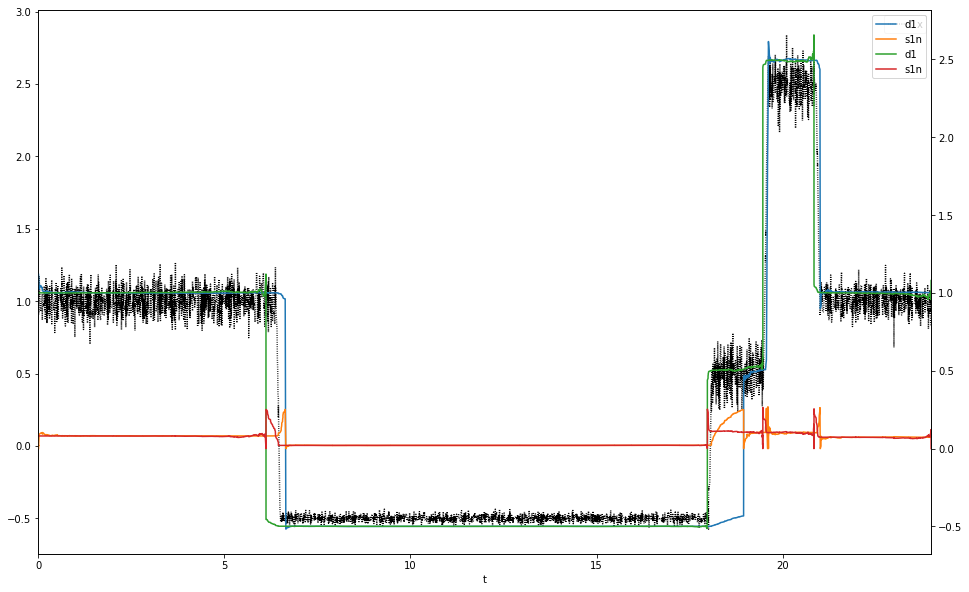

In [28]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t',y=['d1','s1n'],  ax=axt)
pdf_trajr.plot(x='t',y=['d1','s1n'],  ax=axt)
axt.legend()

(-0.002, 0.5)

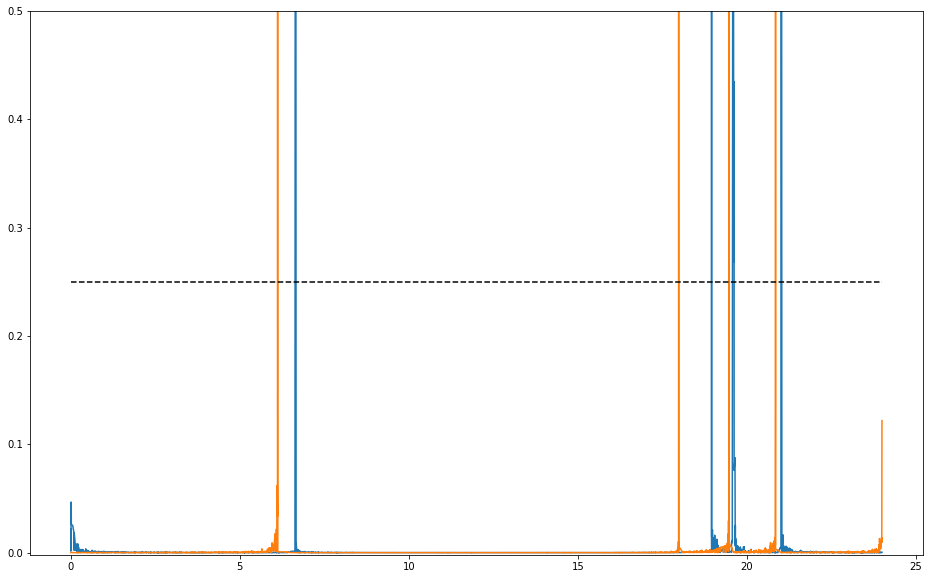

In [34]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.plot(pdf_traj.t.values[1:], abs(pdf_traj.d1.values[1:]-pdf_traj.d1.values[0:-1]))
ax.plot(pdf_trajr.t.values[0:-1], abs(pdf_trajr.d1.values[1:]-pdf_trajr.d1.values[0:-1]))
ax.plot([0,24], [eps,eps], 'k--')
ax.set_ylim([-0.002,0.5])
#ax.set_xlim([5.9,7]);

In [35]:
pdf_traj.t.values[1:]
fdiffs = abs(pdf_traj.d1.values[1:]-pdf_traj.d1.values[0:-1])

pdf_trajr.t.values[0:-1]
bdiffs = abs(pdf_trajr.d1.values[1:]-pdf_trajr.d1.values[0:-1])

fdiffs_mask = np.where(fdiffs > eps)
bdiffs_mask = np.where(bdiffs > eps)



(-0.002, 0.5)

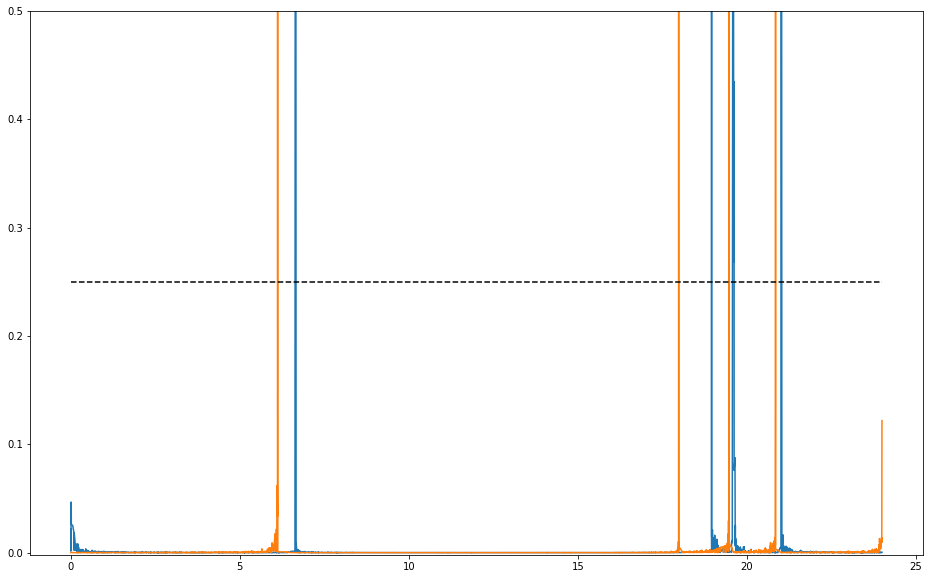

In [45]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.plot(pdf_traj.t.values[1:], fdiffs)
ax.plot(pdf_trajr.t.values[0:-1], bdiffs)
ax.plot([0,24], [eps,eps], 'k--')
ax.set_ylim([-0.002,0.5])
#ax.set_xlim([5.9,7]);

In [36]:
fdiffs_mask

(array([1232, 3428, 3519, 3520, 3521, 3792]),)

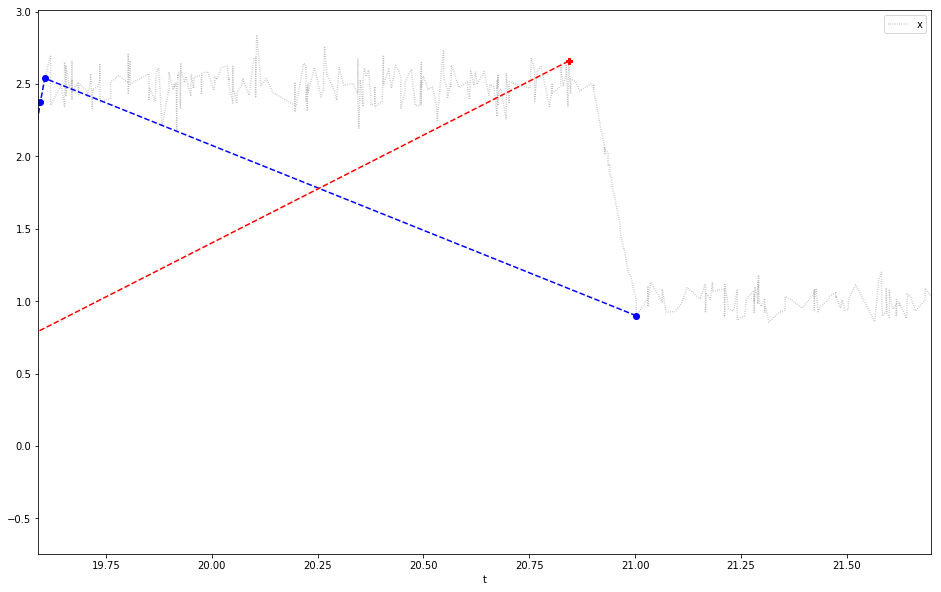

In [51]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

pdf_traj.plot(x='t',y=['x'], color='gray', linestyle='--', dashes=[0.5,1],ax=ax, alpha=0.5)

ax.plot(pdf_traj.t.values[fdiffs_mask],pdf_traj.x.values[fdiffs_mask],'bo--')
ax.plot(pdf_trajr.t.values[bdiffs_mask],pdf_trajr.x.values[bdiffs_mask],'rP--')

ax.legend()
ax.set_xlim([19.59,21.7]);

In [30]:
m = 0
nn = 1
columns=['t', 'x','s1', 's2', 's3', 's4']
pdf_traj = pd.DataFrame(columns=columns)
last_time_point = time_sub[0]
for _ in range(len(noise_journey_sub)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_sub[m:nn])
    cluster_avg = np.mean(noise_journey_sub[m:nn])       

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_sub[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_sub[nn]
    
    s1 = get_norm_diff(cluster_std,  0.25*eps)
    s2 = get_norm_diff(cluster_std,  0.5*eps)
    s3 = get_norm_diff(cluster_std,  1.0*eps)
    s4 = get_norm_diff(cluster_std,  2.0*eps)
    
    pdf_ = pd.DataFrame(data=[[time_sub[nn],next_loc,s1,s2,s3,s4]],
                         columns=columns)
    pdf_traj = pd.concat([pdf_traj, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_sub[nn]
    if s3 > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_traj.reset_index(drop=True, inplace=True)

In [31]:
noise_journey_subr = noise_journey_sub[::-1]
time_subr = time_sub[::-1]

m = 0
nn = 1
columns=['t', 'x','s1', 's2', 's3', 's4']
pdf_trajr = pd.DataFrame(columns=columns)
last_time_point = time_subr[0]
for _ in range(len(noise_journey_subr)-1):
    
    # Some statistics: std, IQR-std, IQR-mean
    cluster_std = np.std(noise_journey_subr[m:nn])
    cluster_avg = np.mean(noise_journey_subr[m:nn])       

    #print(noise_journey_sub[m:nn],cluster_std,noise_journey_sub[nn])
    # Some local info: current x,t
    tval  = get_norm_diff(time_subr[nn]-last_time_point, time_thresh)

    next_loc =noise_journey_subr[nn]
    
    s1 = get_norm_diff(cluster_std,  0.25*eps)
    s2 = get_norm_diff(cluster_std,  0.5*eps)
    s3 = get_norm_diff(cluster_std,  1.0*eps)
    s4 = get_norm_diff(cluster_std,  2.0*eps)
    
    pdf_ = pd.DataFrame(data=[[time_subr[nn],next_loc,s1,s2,s3,s4]],
                         columns=columns)
    pdf_trajr = pd.concat([pdf_trajr, pdf_])
    the_norm1 = norm([x2val,tval])
    the_norm2 = norm([x1val,x2val,s1val,s2val,tval])
    last_time_point = time_subr[nn]
    if s3 > 1.0:
        m=nn
        nn=m+1
    else:
        nn+=1
    #round2 = lambda x: str(round(x,2))+'\t'
    
    #print(*list(map(round2,[x1val,x2val,s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))
    #print(*list(map(round2,[s1val,s2val,tval, the_norm2])), len(noise_journey_sub[m:nn]))

pdf_trajr.reset_index(drop=True, inplace=True)

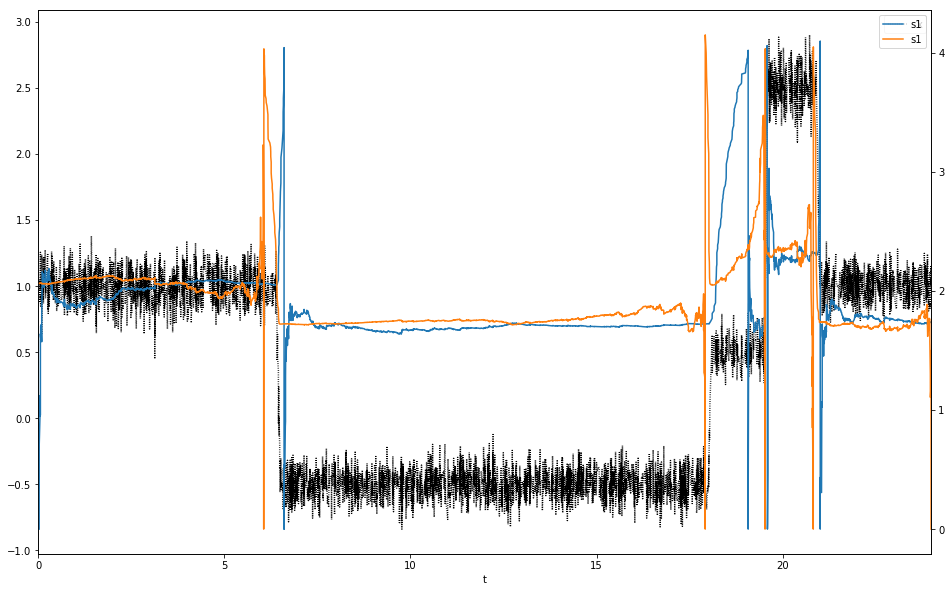

In [32]:
fig, ax = plt.subplots(1,1,figsize=[16,10])
pdf_traj.plot(x='t',y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1'], ax=axt)
pdf_trajr.plot(x='t', y=['s1'], ax=axt)
axt.legend()

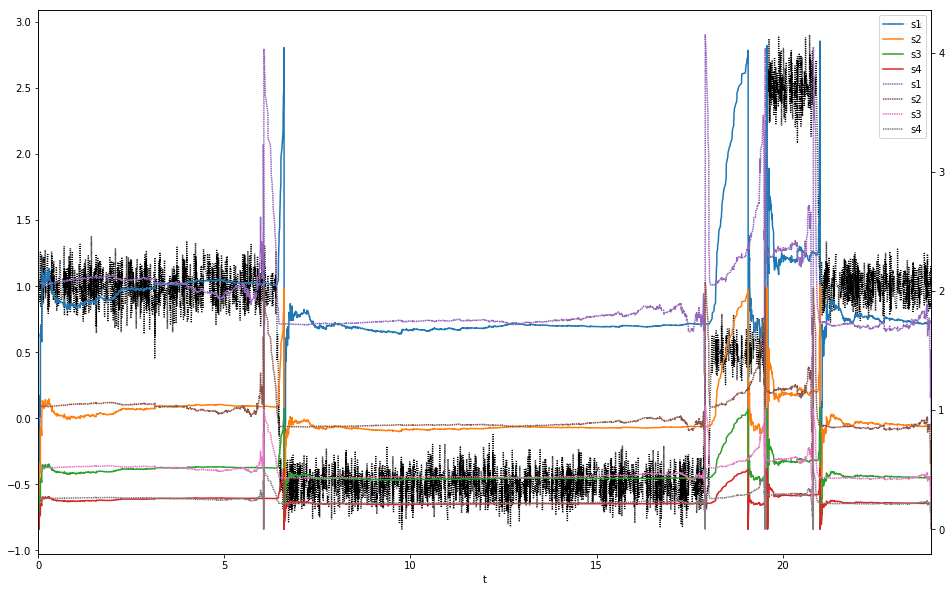

In [33]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 


pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1','s2','s3','s4'],  ax=axt)
pdf_trajr.plot(x='t', y=['s1','s2','s3','s4'], dashes=[1,0.5], ax=axt)
axt.legend()

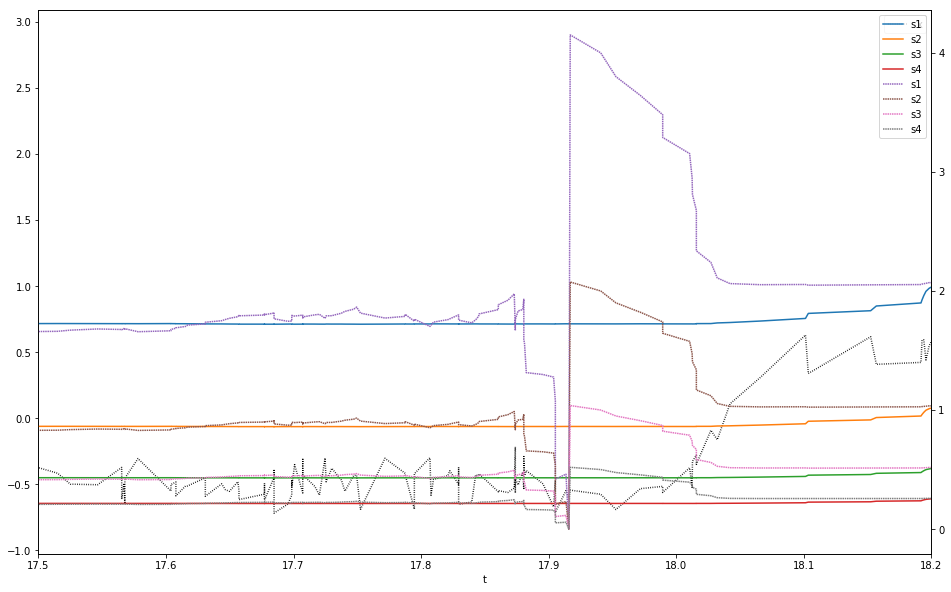

In [145]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 


pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
pdf_traj.plot(x='t', y=['s1','s2','s3','s4'],  ax=axt)
pdf_trajr.plot(x='t', y=['s1','s2','s3','s4'], dashes=[1,0.5], ax=axt)
axt.legend()
plt.xlim([17.5,18.2]);

No handles with labels found to put in legend.


(5, 24)

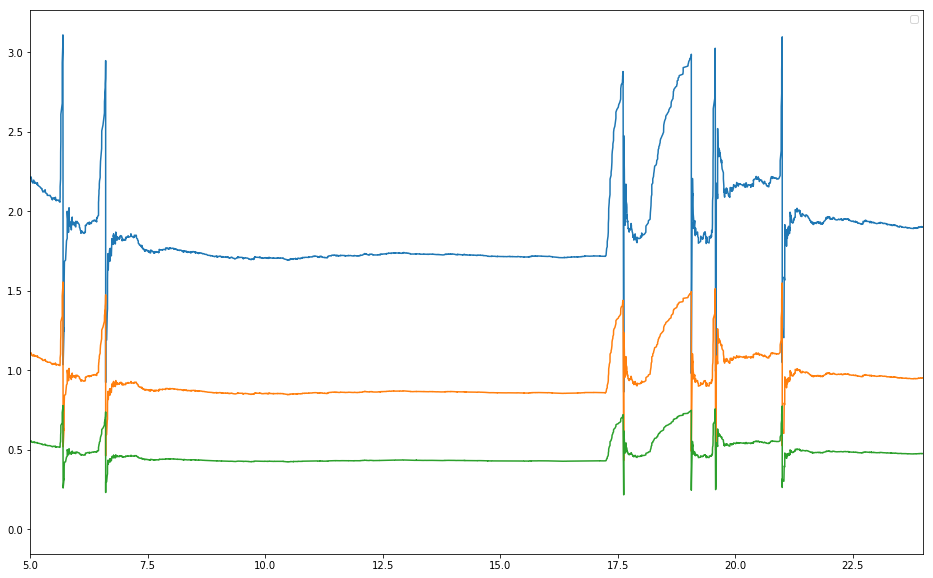

In [34]:
fig, axt = plt.subplots(1,1,figsize=[16,10])

colors=['C1','C1','C2','C4'], 

'''pdf_traj.plot(x='t', y=['x'], color='k',linestyle='--', dashes=[0.5,1],ax=ax)
ax.legend()

axt = ax.twinx()
'''#pdf_traj.plot(y=['d1','qd','s1','qs'], ax=axt)
#pdf_traj.plot(x='t', y=['s1'],  ax=axt)
#pdf_trajr.plot(x='t', y=['s1'], dashes=[1,0.5], ax=axt)

plt.plot(pdf_traj.t.values, abs(pdf_traj.s1.values + pdf_trajr.s1.values)/2)
plt.plot(pdf_traj.t.values, abs(pdf_traj.s2.values + pdf_trajr.s2.values)/2)
plt.plot(pdf_traj.t.values, abs(pdf_traj.s3.values + pdf_trajr.s3.values)/2)

axt.legend()
plt.xlim([5,24])
#ax.set_ylim([-1.0, 1.5])
#axt.set_ylim([-1.0, 5.0])

In [146]:
pdf_traj[(pdf_traj['t']>=17.8) & (pdf_traj['t']<18.1)]

,t,x,s1,s2,s3,s4
3262,17.806944,-0.298655,1.722171,0.861086,0.430543,0.215271
3263,17.807778,-0.581690,1.723180,0.861590,0.430795,0.215397
3264,17.809722,-0.463250,1.723015,0.861507,0.430754,0.215377
3265,17.821111,-0.433172,1.722645,0.861322,0.430661,0.215331
3266,17.822500,-0.397653,1.722382,0.861191,0.430595,0.215298
3267,17.829444,-0.500588,1.722329,0.861164,0.430582,0.215291
3268,17.829444,-0.369829,1.721916,0.860958,0.430479,0.215239
3269,17.829444,-0.651470,1.722089,0.861045,0.430522,0.215261
3270,17.839722,-0.633120,1.722514,0.861257,0.430629,0.215314
3271,17.842778,-0.429295,1.722750,0.861375,0.430688,0.215344


In [ ]:
pdf_traj[(pdf_traj['t']>=6.6) & (pdf_traj['t']<7.0)]

In [ ]:
1184

In [36]:
pdf_traj.head(80).tail(10)

,t,x,s1,s2,s3,s4
70,0.410833,1.129956,1.985297,0.992648,0.496324,0.248162
71,0.410833,1.157815,1.982591,0.991296,0.495648,0.247824
72,0.410833,1.022317,1.985703,0.992851,0.496426,0.248213
73,0.413333,1.124907,1.972241,0.986120,0.493060,0.246530
74,0.417500,1.102807,1.968238,0.984119,0.492060,0.246030
75,0.421389,1.181974,1.960685,0.980342,0.490171,0.245086
76,0.421667,1.106308,1.968867,0.984434,0.492217,0.246108
77,0.424722,0.969146,1.961556,0.980778,0.490389,0.245194
78,0.433333,1.074572,1.951838,0.975919,0.487959,0.243980
79,0.434167,0.904019,1.941507,0.970754,0.485377,0.242688
